In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install necessary libraries
!pip install torchaudio timm librosa matplotlib pandas scikit-learn torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 51.2 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.12
    Uninstalling sympy-1.12:
      Successfully uninstalled sympy-1.12


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import librosa
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn as nn
import torch.optim as optim


DATASET_DIR = "/content/drive/MyDrive/ICBHI_final_database"
LABEL_PATH = "/content/drive/MyDrive/wheeze_labels_filtered.csv"

# Label Extraction

data = []
for fname in os.listdir(DATASET_DIR):
    if fname.endswith(".txt"):
        wav_name = fname.replace(".txt", ".wav")
        wav_path = os.path.join(DATASET_DIR, wav_name)

        if not os.path.exists(wav_path):
            continue

        txt_path = os.path.join(DATASET_DIR, fname)
        wheeze_vals = []
        with open(txt_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 4:
                    try:
                        wheeze = int(parts[-1])
                        wheeze_vals.append(wheeze)
                    except ValueError:
                        continue

        has_wheeze = int(any(wheeze_vals))
        data.append((wav_name, has_wheeze))

df = pd.DataFrame(data, columns=["filename", "wheeze_label"])
df['full_path'] = df['filename'].apply(lambda x: os.path.join(DATASET_DIR, x))
df = df[df['full_path'].apply(os.path.exists)].reset_index(drop=True)
df.to_csv(LABEL_PATH, index=False)

In [ ]:
# Log-Mel Spectrogram Conversion

def audio_to_logmel(filepath, sr=16000, n_fft=1024, hop_length=512, n_mels=128):
    y, _ = librosa.load(filepath, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                         hop_length=hop_length, n_mels=n_mels)
    log_mel = librosa.power_to_db(mel, ref=np.max)
    return log_mel

In [ ]:
# Dataset Class

class RespiratoryDataset(Dataset):
    def __init__(self, df, sr=16000):
        self.df = df
        self.sr = sr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filepath = row['full_path']
        label = row['wheeze_label']

        log_mel = audio_to_logmel(filepath, sr=self.sr)

        # Convert to 3-channel, 224x224 image
        log_mel_tensor = torch.tensor(log_mel).unsqueeze(0)
        log_mel_resized = torch.nn.functional.interpolate(
            log_mel_tensor.unsqueeze(0), size=(224, 224), mode='bilinear'
        ).squeeze(0)
        log_mel_rgb = log_mel_resized.repeat(3, 1, 1)

        return log_mel_rgb, torch.tensor(label, dtype=torch.float32)

In [ ]:
# Split the Train/Validation dataset

df = pd.read_csv(LABEL_PATH)
df['full_path'] = df['filename'].apply(lambda x: os.path.join(DATASET_DIR, x))
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['wheeze_label'])

train_dataset = RespiratoryDataset(train_df)
val_dataset = RespiratoryDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
# Custom CNN model with 4 convolutional layers

class CNNWheezeClassifier(nn.Module):
    def __init__(self):
        super(CNNWheezeClassifier, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Initialize model, optimizer, and loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNWheezeClassifier().to(device)

label_counts = df['wheeze_label'].value_counts()
neg, pos = label_counts[0], label_counts[1]
pos_weight = torch.tensor([neg / pos]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training

for epoch in range(30):
    model.train()
    train_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).view(-1)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    preds_list, probs_list, targets_list = [], [], []
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).view(-1)
            loss = criterion(preds, y)
            val_loss += loss.item()

            probs = torch.sigmoid(preds)
            preds_list.extend((probs > 0.5).int().cpu().numpy())
            probs_list.extend(probs.cpu().numpy())
            targets_list.extend(y.cpu().numpy())

    acc = accuracy_score(targets_list, preds_list)
    f1 = f1_score(targets_list, preds_list)
    auc = roc_auc_score(targets_list, probs_list)
    print(f"CNN Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


CNN Epoch 1 | Train Loss: 80.8760 | Val Loss: 19.4256 | Acc: 0.5272 | F1: 0.5584 | AUC: 0.6667
CNN Epoch 2 | Train Loss: 80.1560 | Val Loss: 19.6861 | Acc: 0.6304 | F1: 0.3929 | AUC: 0.6642
CNN Epoch 3 | Train Loss: 80.0513 | Val Loss: 19.3491 | Acc: 0.5326 | F1: 0.5743 | AUC: 0.6687
CNN Epoch 4 | Train Loss: 78.5516 | Val Loss: 18.9278 | Acc: 0.5217 | F1: 0.5556 | AUC: 0.6727
CNN Epoch 5 | Train Loss: 77.9157 | Val Loss: 18.5463 | Acc: 0.6033 | F1: 0.5629 | AUC: 0.6886


In [ ]:
# ResNet-50

import os
import pandas as pd
import numpy as np
import torch
import librosa
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.transforms import Normalize

class ResNet50WheezeClassifier(nn.Module):
    def __init__(self):
        super(ResNet50WheezeClassifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

    def forward(self, x):
        return self.model(x)

# Initialize model, optimizer, and loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50WheezeClassifier().to(device)

label_counts = df['wheeze_label'].value_counts()
neg, pos = label_counts[0], label_counts[1]
pos_weight = torch.tensor([neg / pos]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training

for epoch in range(30):
    model.train()
    train_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).view(-1)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    preds_list, probs_list, targets_list = [], [], []
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).view(-1)
            loss = criterion(preds, y)
            val_loss += loss.item()

            probs = torch.sigmoid(preds)
            preds_list.extend((probs > 0.5).int().cpu().numpy())
            probs_list.extend(probs.cpu().numpy())
            targets_list.extend(y.cpu().numpy())

    acc = accuracy_score(targets_list, preds_list)
    f1 = f1_score(targets_list, preds_list)
    auc = roc_auc_score(targets_list, probs_list)
    print(f"ResNet50 Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 118MB/s]


ResNet50 Epoch 1 | Train Loss: 75.2109 | Val Loss: 17.2378 | Acc: 0.7500 | F1: 0.5741 | AUC: 0.7623


KeyboardInterrupt: 

In [ ]:
# GoogLeNet Inception-v1

import os
import pandas as pd
import numpy as np
import torch
import librosa
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.transforms import Normalize, ToPILImage, ToTensor, Resize, Compose, ColorJitter, RandomHorizontalFlip, RandomVerticalFlip

class GoogleNetWheezeClassifier(nn.Module):
    def __init__(self):
        super(GoogleNetWheezeClassifier, self).__init__()
        self.model = models.googlenet(pretrained=True, aux_logits=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

    def forward(self, x):
        output = self.model(x)
        if isinstance(output, tuple) or hasattr(output, 'logits'):
            return output.logits
        return output

# Initialize model, optimizer, and loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GoogleNetWheezeClassifier().to(device)

label_counts = df['wheeze_label'].value_counts()
neg, pos = label_counts[0], label_counts[1]
pos_weight = torch.tensor([neg / pos]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training

for epoch in range(30):
    model.train()
    train_loss = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).view(-1)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    preds_list, probs_list, targets_list = [], [], []
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).view(-1)
            loss = criterion(preds, y)
            val_loss += loss.item()

            probs = torch.sigmoid(preds)
            preds_list.extend((probs > 0.5).int().cpu().numpy())
            probs_list.extend(probs.cpu().numpy())
            targets_list.extend(y.cpu().numpy())

    acc = accuracy_score(targets_list, preds_list)
    f1 = f1_score(targets_list, preds_list)
    auc = roc_auc_score(targets_list, probs_list)
    print(f"GoogleNet Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


AttributeError: module 'sympy' has no attribute 'core'

Visualization Part

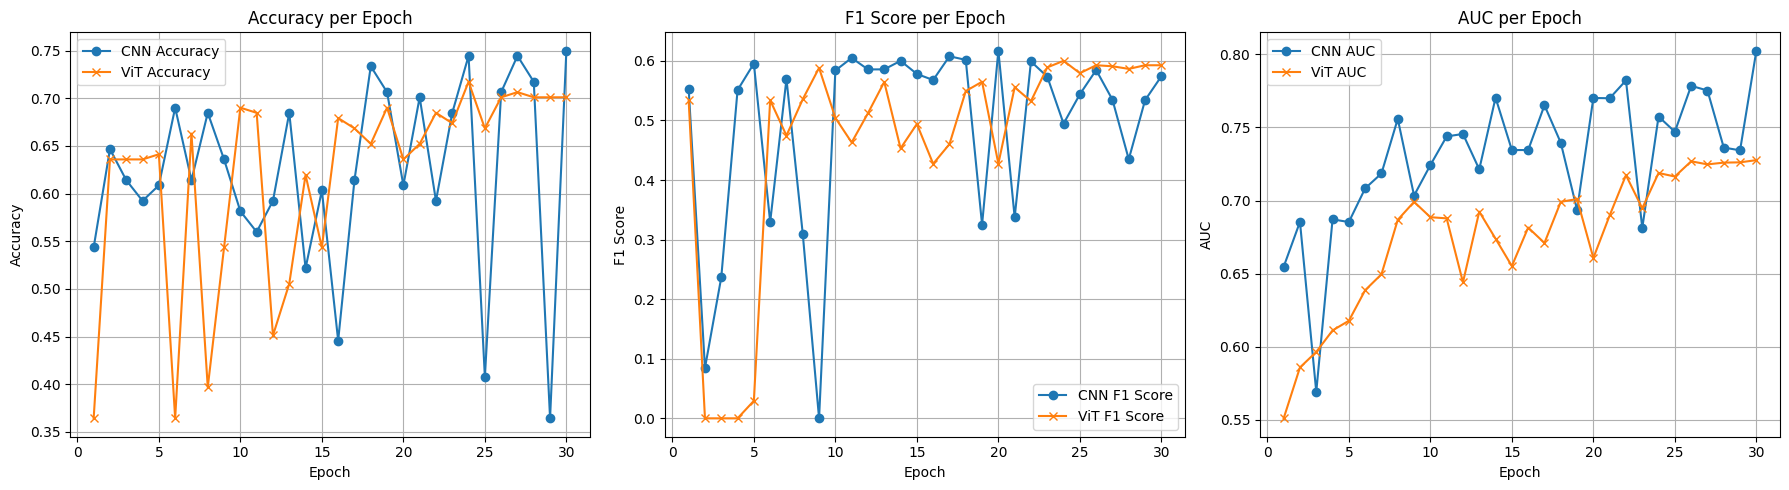

In [ ]:
# Comparison Table (ViT-Base-256 model vs Custom CNN)

import matplotlib.pyplot as plt

# Custom CNN Performance Results
cnn_epochs = list(range(1, 31))
cnn_acc = [0.5435, 0.6467, 0.6141, 0.5924, 0.6087, 0.6902, 0.6141, 0.6848, 0.6359, 0.5815,
            0.5598, 0.5924, 0.6848, 0.5217, 0.6033, 0.4457, 0.6141, 0.7337, 0.7065, 0.6087,
            0.7011, 0.5924, 0.6848, 0.7446, 0.4076, 0.7065, 0.7446, 0.7174, 0.3641, 0.7500]
cnn_f1 = [0.5532, 0.0845, 0.2366, 0.5509, 0.5955, 0.3294, 0.5697, 0.3095, 0.0000, 0.5838,
           0.6049, 0.5856, 0.5857, 0.6000, 0.5780, 0.5678, 0.6077, 0.6016, 0.3250, 0.6170,
           0.3373, 0.5989, 0.5735, 0.4946, 0.5439, 0.5846, 0.5347, 0.4348, 0.5339, 0.5741]
cnn_auc = [0.6547, 0.6854, 0.5692, 0.6871, 0.6853, 0.7083, 0.7185, 0.7558, 0.7034, 0.7242,
            0.7438, 0.7455, 0.7213, 0.7703, 0.7345, 0.7345, 0.7651, 0.7395, 0.6936, 0.7701,
            0.7699, 0.7821, 0.6812, 0.7574, 0.7470, 0.7784, 0.7752, 0.7362, 0.7343, 0.8024]

# BiT-Base-256 Performance Results
vit_epochs = list(range(1, 31))
vit_acc = [0.3641, 0.6359, 0.6359, 0.6359, 0.6413, 0.3641, 0.6630, 0.3967, 0.5435, 0.6902,
            0.6848, 0.4511, 0.5054, 0.6196, 0.5435, 0.6793, 0.6685, 0.6522, 0.6902, 0.6359,
            0.6522, 0.6848, 0.6739, 0.7174, 0.6685, 0.7011, 0.7065, 0.7011, 0.7011, 0.7011]
vit_f1 = [0.5339, 0.0000, 0.0000, 0.0000, 0.0294, 0.5339, 0.4746, 0.5356, 0.5882, 0.5043,
           0.4630, 0.5121, 0.5646, 0.4531, 0.4940, 0.4272, 0.4602, 0.5493, 0.5649, 0.4274,
           0.5556, 0.5323, 0.5890, 0.6000, 0.5793, 0.5926, 0.5909, 0.5865, 0.5926, 0.5926]
vit_auc = [0.5511, 0.5859, 0.5965, 0.6112, 0.6178, 0.6387, 0.6496, 0.6868, 0.6991, 0.6886,
            0.6878, 0.6441, 0.6924, 0.6739, 0.6552, 0.6815, 0.6710, 0.6991, 0.7010, 0.6607,
            0.6898, 0.7173, 0.6947, 0.7188, 0.7164, 0.7268, 0.7247, 0.7259, 0.7261, 0.7276]

# Draw a graph
plt.figure(figsize=(18,5))

# Accuracy Graph
plt.subplot(1,3,1)
plt.plot(cnn_epochs, cnn_acc, label='CNN Accuracy', marker='o')
plt.plot(vit_epochs, vit_acc, label='ViT Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid()

# F1-Score Graph
plt.subplot(1,3,2)
plt.plot(cnn_epochs, cnn_f1, label='CNN F1 Score', marker='o')
plt.plot(vit_epochs, vit_f1, label='ViT F1 Score', marker='x')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.legend()
plt.grid()

# AUC Graph
plt.subplot(1,3,3)
plt.plot(cnn_epochs, cnn_auc, label='CNN AUC', marker='o')
plt.plot(vit_epochs, vit_auc, label='ViT AUC', marker='x')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC per Epoch')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

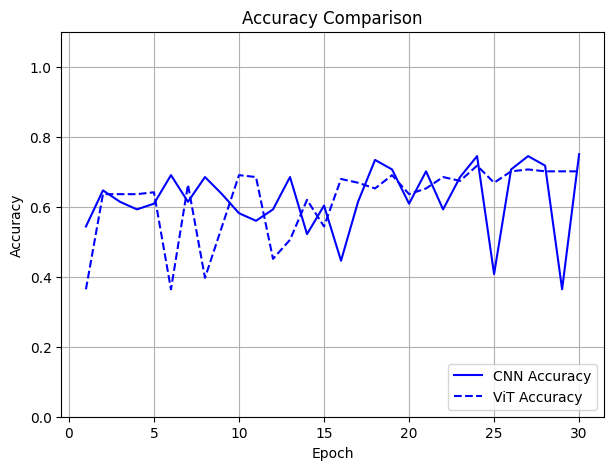

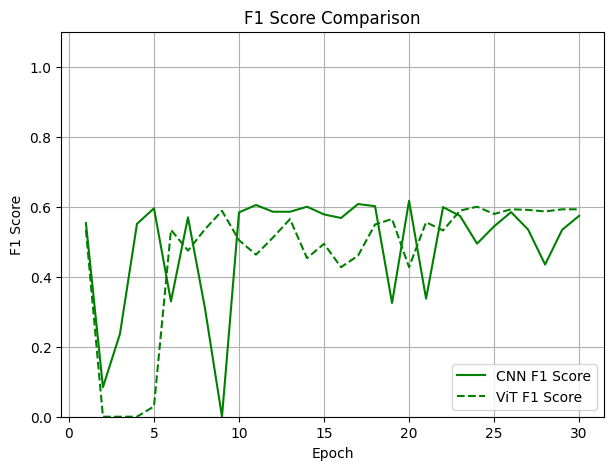

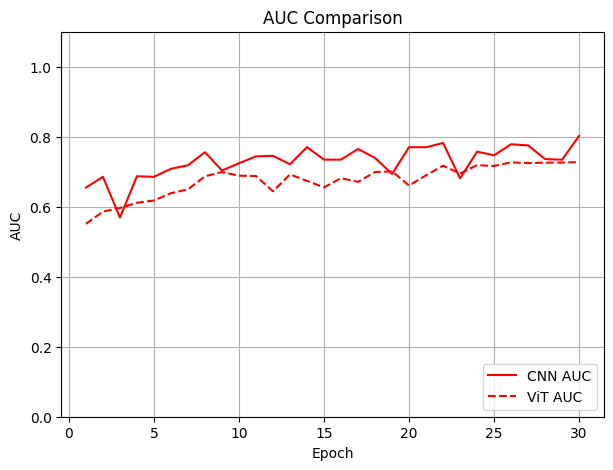

In [ ]:
# ViT-Base-256 vs. Custom CNN Comparison Graph (Better readability Version)

import matplotlib.pyplot as plt

epochs = list(range(1, 31))

# CNN
cnn_acc = [0.5435, 0.6467, 0.6141, 0.5924, 0.6087, 0.6902, 0.6141, 0.6848, 0.6359, 0.5815,
           0.5598, 0.5924, 0.6848, 0.5217, 0.6033, 0.4457, 0.6141, 0.7337, 0.7065, 0.6087,
           0.7011, 0.5924, 0.6848, 0.7446, 0.4076, 0.7065, 0.7446, 0.7174, 0.3641, 0.7500]
cnn_f1 = [0.5532, 0.0845, 0.2366, 0.5509, 0.5955, 0.3294, 0.5697, 0.3095, 0.0000, 0.5838,
          0.6049, 0.5856, 0.5857, 0.6000, 0.5780, 0.5678, 0.6077, 0.6016, 0.3250, 0.6170,
          0.3373, 0.5989, 0.5735, 0.4946, 0.5439, 0.5846, 0.5347, 0.4348, 0.5339, 0.5741]
cnn_auc = [0.6547, 0.6854, 0.5692, 0.6871, 0.6853, 0.7083, 0.7185, 0.7558, 0.7034, 0.7242,
           0.7438, 0.7455, 0.7213, 0.7703, 0.7345, 0.7345, 0.7651, 0.7395, 0.6936, 0.7701,
           0.7699, 0.7821, 0.6812, 0.7574, 0.7470, 0.7784, 0.7752, 0.7362, 0.7343, 0.8024]

# ViT
vit_acc = [0.3641, 0.6359, 0.6359, 0.6359, 0.6413, 0.3641, 0.6630, 0.3967, 0.5435, 0.6902,
           0.6848, 0.4511, 0.5054, 0.6196, 0.5435, 0.6793, 0.6685, 0.6522, 0.6902, 0.6359,
           0.6522, 0.6848, 0.6739, 0.7174, 0.6685, 0.7011, 0.7065, 0.7011, 0.7011, 0.7011]
vit_f1 = [0.5339, 0.0000, 0.0000, 0.0000, 0.0294, 0.5339, 0.4746, 0.5356, 0.5882, 0.5043,
          0.4630, 0.5121, 0.5646, 0.4531, 0.4940, 0.4272, 0.4602, 0.5493, 0.5649, 0.4274,
          0.5556, 0.5323, 0.5890, 0.6000, 0.5793, 0.5926, 0.5909, 0.5865, 0.5926, 0.5926]
vit_auc = [0.5511, 0.5859, 0.5965, 0.6112, 0.6178, 0.6387, 0.6496, 0.6868, 0.6991, 0.6886,
           0.6878, 0.6441, 0.6924, 0.6739, 0.6552, 0.6815, 0.6710, 0.6991, 0.7010, 0.6607,
           0.6898, 0.7173, 0.6947, 0.7188, 0.7164, 0.7268, 0.7247, 0.7259, 0.7261, 0.7276]

# Accuracy
plt.figure(figsize=(7,5))
plt.plot(epochs, cnn_acc, label='CNN Accuracy', color='blue', linestyle='-')
plt.plot(epochs, vit_acc, label='ViT Accuracy', color='blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0, 1.1)
plt.show()

# F1-Score
plt.figure(figsize=(7,5))
plt.plot(epochs, cnn_f1, label='CNN F1 Score', color='green', linestyle='-')
plt.plot(epochs, vit_f1, label='ViT F1 Score', color='green', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0, 1.1)
plt.show()

# AUC
plt.figure(figsize=(7,5))
plt.plot(epochs, cnn_auc, label='CNN AUC', color='red', linestyle='-')
plt.plot(epochs, vit_auc, label='ViT AUC', color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.ylim(0, 1.1)
plt.show()

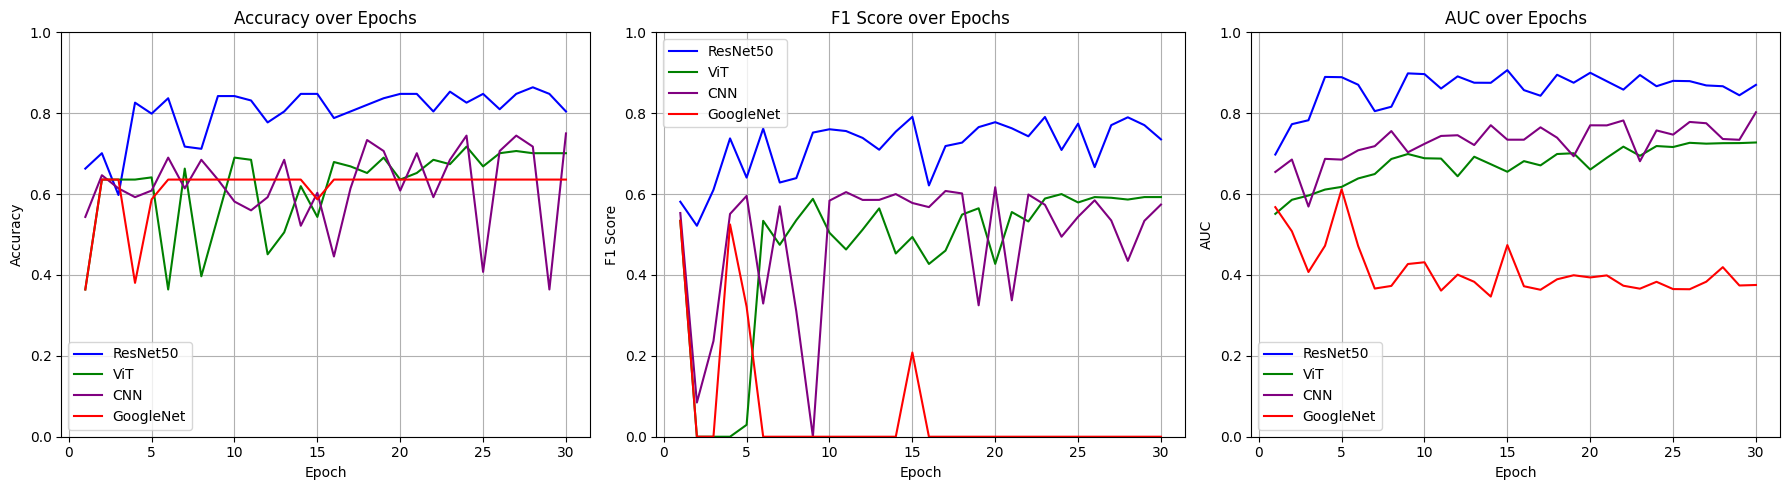

In [ ]:
# ViT-Base-256 VS. Custom CNN VS. ResNet-50 VS. GoogLeNet Inception-v1
# Comparison Graph

import matplotlib.pyplot as plt

epochs = list(range(1, 31))

# ResNet-50
resnet_acc = [0.6630, 0.7011, 0.5978, 0.8261, 0.7989, 0.8370, 0.7174, 0.7120, 0.8424, 0.8424,
              0.8315, 0.7772, 0.8043, 0.8478, 0.8478, 0.7880, 0.8043, 0.8207, 0.8370, 0.8478,
              0.8478, 0.8043, 0.8533, 0.8261, 0.8478, 0.8098, 0.8478, 0.8641, 0.8478, 0.8043]
resnet_f1 = [0.5811, 0.5217, 0.6105, 0.7377, 0.6408, 0.7619, 0.6286, 0.6395, 0.7521, 0.7603,
             0.7559, 0.7389, 0.7097, 0.7544, 0.7910, 0.6214, 0.7188, 0.7273, 0.7656, 0.7778,
             0.7627, 0.7429, 0.7907, 0.7091, 0.7742, 0.6667, 0.7705, 0.7899, 0.7705, 0.7353]
resnet_auc = [0.6978, 0.7729, 0.7826, 0.8897, 0.8891, 0.8704, 0.8051, 0.8160, 0.8985, 0.8967,
              0.8610, 0.8911, 0.8754, 0.8752, 0.9065, 0.8571, 0.8432, 0.8951, 0.8754, 0.9000,
              0.8791, 0.8583, 0.8944, 0.8667, 0.8800, 0.8793, 0.8687, 0.8667, 0.8444, 0.8701]

# ViT-Base-256
vit_acc = [0.3641, 0.6359, 0.6359, 0.6359, 0.6413, 0.3641, 0.6630, 0.3967, 0.5435, 0.6902,
           0.6848, 0.4511, 0.5054, 0.6196, 0.5435, 0.6793, 0.6685, 0.6522, 0.6902, 0.6359,
           0.6522, 0.6848, 0.6739, 0.7174, 0.6685, 0.7011, 0.7065, 0.7011, 0.7011, 0.7011]
vit_f1 = [0.5339, 0.0000, 0.0000, 0.0000, 0.0294, 0.5339, 0.4746, 0.5356, 0.5882, 0.5043,
          0.4630, 0.5121, 0.5646, 0.4531, 0.4940, 0.4272, 0.4602, 0.5493, 0.5649, 0.4274,
          0.5556, 0.5323, 0.5890, 0.6000, 0.5793, 0.5926, 0.5909, 0.5865, 0.5926, 0.5926]
vit_auc = [0.5511, 0.5859, 0.5965, 0.6112, 0.6178, 0.6387, 0.6496, 0.6868, 0.6991, 0.6886,
           0.6878, 0.6441, 0.6924, 0.6739, 0.6552, 0.6815, 0.6710, 0.6991, 0.7010, 0.6607,
           0.6898, 0.7173, 0.6947, 0.7188, 0.7164, 0.7268, 0.7247, 0.7259, 0.7261, 0.7276]

# Custom CNN (4 conv layers)
cnn_acc = [0.5435, 0.6467, 0.6141, 0.5924, 0.6087, 0.6902, 0.6141, 0.6848, 0.6359, 0.5815,
           0.5598, 0.5924, 0.6848, 0.5217, 0.6033, 0.4457, 0.6141, 0.7337, 0.7065, 0.6087,
           0.7011, 0.5924, 0.6848, 0.7446, 0.4076, 0.7065, 0.7446, 0.7174, 0.3641, 0.7500]
cnn_f1 = [0.5532, 0.0845, 0.2366, 0.5509, 0.5955, 0.3294, 0.5697, 0.3095, 0.0000, 0.5838,
          0.6049, 0.5856, 0.5857, 0.6000, 0.5780, 0.5678, 0.6077, 0.6016, 0.3250, 0.6170,
          0.3373, 0.5989, 0.5735, 0.4946, 0.5439, 0.5846, 0.5347, 0.4348, 0.5339, 0.5741]
cnn_auc = [0.6547, 0.6854, 0.5692, 0.6871, 0.6853, 0.7083, 0.7185, 0.7558, 0.7034, 0.7242,
           0.7438, 0.7455, 0.7213, 0.7703, 0.7345, 0.7345, 0.7651, 0.7395, 0.6936, 0.7701,
           0.7699, 0.7821, 0.6812, 0.7574, 0.7470, 0.7784, 0.7752, 0.7362, 0.7343, 0.8024]

# GoogleNet Inception-v1
googlenet_acc = [
    0.3641, 0.6359, 0.6359, 0.3804, 0.5870, 0.6359, 0.6359, 0.6359, 0.6359, 0.6359,
    0.6359, 0.6359, 0.6359, 0.6359, 0.5870, 0.6359, 0.6359, 0.6359, 0.6359, 0.6359,
    0.6359, 0.6359, 0.6359, 0.6359, 0.6359, 0.6359, 0.6359, 0.6359, 0.6359, 0.6359
]
googlenet_f1 = [
    0.5339, 0.0000, 0.0000, 0.5250, 0.3214, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
    0.0000, 0.0000, 0.0000, 0.0000, 0.2083, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
    0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
]
googlenet_auc = [
    0.5677, 0.5080, 0.4073, 0.4723, 0.6119, 0.4715, 0.3664, 0.3729, 0.4271, 0.4314,
    0.3613, 0.4008, 0.3831, 0.3466, 0.4739, 0.3721, 0.3634, 0.3893, 0.3993, 0.3939,
    0.3989, 0.3734, 0.3661, 0.3831, 0.3651, 0.3647, 0.3833, 0.4193, 0.3740, 0.3752
]

plt.figure(figsize=(18, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs, resnet_acc, label='ResNet50', color='blue')
plt.plot(epochs, vit_acc, label='ViT', color='green')
plt.plot(epochs, cnn_acc, label='CNN', color='purple')
plt.plot(epochs, googlenet_acc, label='GoogleNet', color='red')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# F1 Score
plt.subplot(1, 3, 2)
plt.plot(epochs, resnet_f1, label='ResNet50', color='blue')
plt.plot(epochs, vit_f1, label='ViT', color='green')
plt.plot(epochs, cnn_f1, label='CNN', color='purple')
plt.plot(epochs, googlenet_f1, label='GoogleNet', color='red')
plt.title('F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, resnet_auc, label='ResNet50', color='blue')
plt.plot(epochs, vit_auc, label='ViT', color='green')
plt.plot(epochs, cnn_auc, label='CNN', color='purple')
plt.plot(epochs, googlenet_auc, label='GoogleNet', color='red')
plt.title('AUC over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

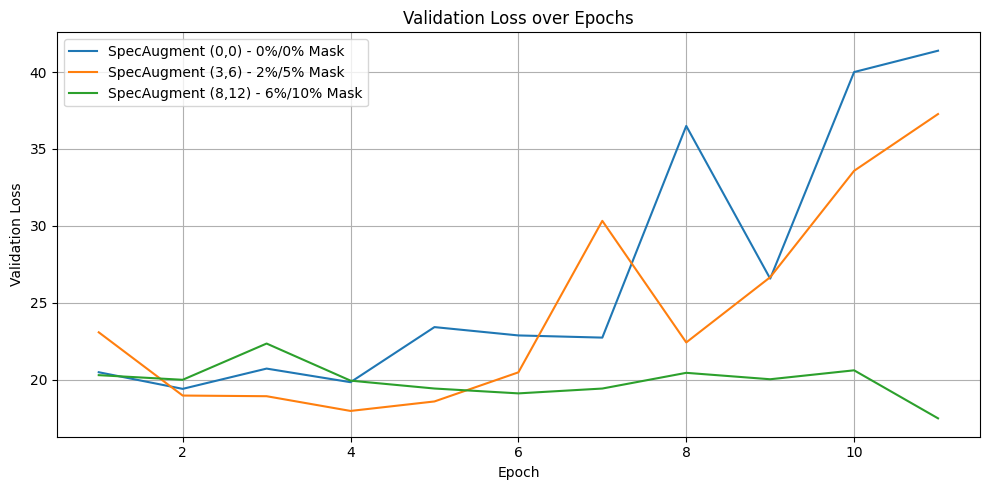

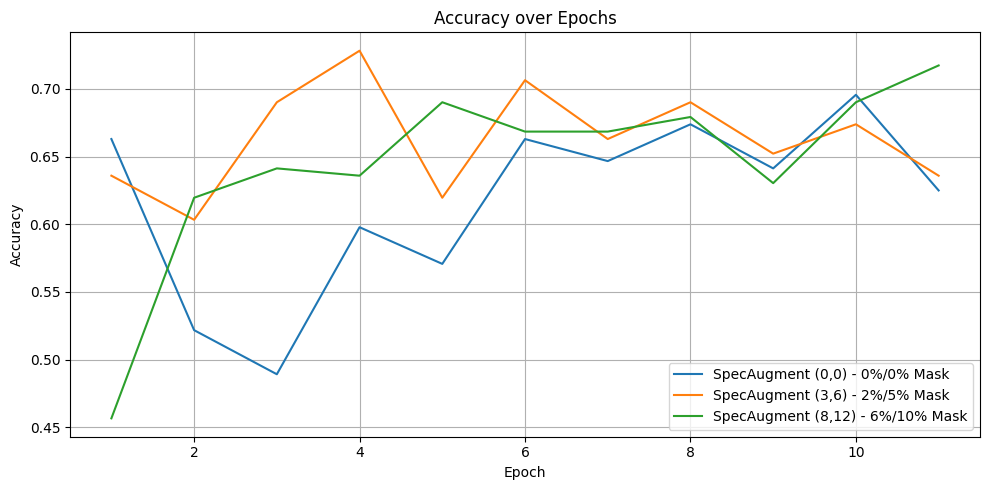

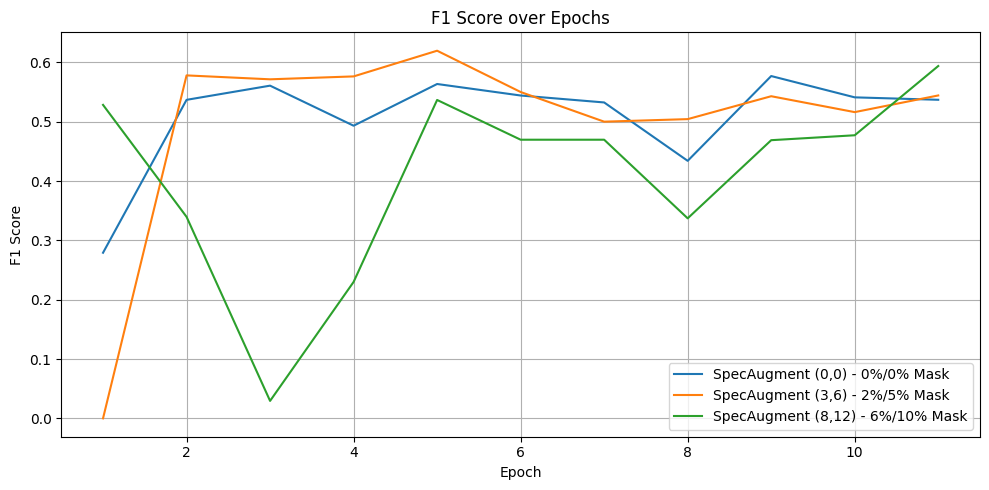

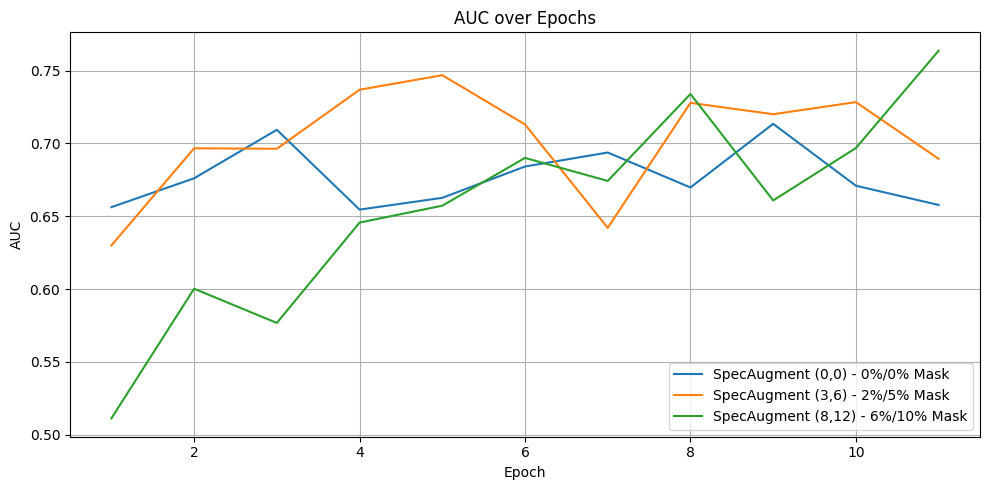

In [ ]:
# Comparison of SpecAugmented ViT performances (different masking)

import matplotlib.pyplot as plt

epochs = list(range(1, 12))

# SpecAugment (0,0) - 0%/0% Mask
exp1 = {
    "val_loss": [20.4829, 19.4020, 20.7199, 19.8355, 23.4179, 22.8759, 22.7343, 36.4970, 26.5698, 40.0013, 41.3885],
    "acc":      [0.6630, 0.5217, 0.4891, 0.5978, 0.5707, 0.6630, 0.6467, 0.6739, 0.6413, 0.6957, 0.6250],
    "f1":       [0.2791, 0.5368, 0.5607, 0.4932, 0.5635, 0.5441, 0.5324, 0.4340, 0.5769, 0.5410, 0.5369],
    "auc":      [0.6562, 0.6760, 0.7093, 0.6545, 0.6626, 0.6841, 0.6937, 0.6697, 0.7134, 0.6709, 0.6577],
}

# "SpecAugment (3,6) - 2%/5% Mask"
exp2 = {
    "val_loss": [23.0791, 18.9671, 18.9241, 17.9665, 18.5835, 20.4763, 30.3260, 22.4209, 26.6610, 33.5794, 37.2706],
    "acc":      [0.6359, 0.6033, 0.6902, 0.7283, 0.6196, 0.7065, 0.6630, 0.6902, 0.6522, 0.6739, 0.6359],
    "f1":       [0.0000, 0.5780, 0.5714, 0.5763, 0.6196, 0.5500, 0.5000, 0.5043, 0.5429, 0.5161, 0.5442],
    "auc":      [0.6299, 0.6966, 0.6963, 0.7368, 0.7468, 0.7130, 0.6420, 0.7278, 0.7200, 0.7283, 0.6894],
}

# "SpecAugment (8,12) - 6%/10% Mask"
exp3 = {
    "val_loss": [20.2930, 19.9918, 22.3484, 19.9361, 19.4239, 19.1082, 19.4230, 20.4445, 20.0269, 20.6081, 17.4852],
    "acc":      [0.4565, 0.6196, 0.6413, 0.6359, 0.6902, 0.6685, 0.6685, 0.6793, 0.6304, 0.6902, 0.7174],
    "f1":       [0.5283, 0.3396, 0.0294, 0.2299, 0.5366, 0.4696, 0.4696, 0.3371, 0.4688, 0.4771, 0.5938],
    "auc":      [0.5112, 0.6002, 0.5767, 0.6456, 0.6572, 0.6900, 0.6742, 0.7339, 0.6608, 0.6968, 0.7636],
}

def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, exp1[metric_name], label='SpecAugment (0,0) - 0%/0% Mask')
    plt.plot(epochs, exp2[metric_name], label='SpecAugment (3,6) - 2%/5% Mask')
    plt.plot(epochs, exp3[metric_name], label='SpecAugment (8,12) - 6%/10% Mask')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric("val_loss", "Validation Loss")
plot_metric("acc", "Accuracy")
plot_metric("f1", "F1 Score")
plot_metric("auc", "AUC")